# Examination of component clustering

Q: Which is better, clustering based off of Jaccard index, or simply taking the mean of components?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from descartes import PolygonPatch
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as st
import pandas as pd
import gzbuilder_analysis.aggregation as ag
import gzbuilder_analysis.rendering.jax.fit as fit

In [2]:
true_model = dict(
    disk=dict(mux=51, muy=51, roll=np.pi/5, I=1, q=0.8, Re=15, n=1, c=2),
    bulge=dict(mux=50.6, muy=51.4, roll=0, I=1, q=0.94, Re=3, n=1.3),
    bar=dict(mux=51, muy=51, roll=0.4*np.pi, I=1, q=0.31, Re=7, n=0.8),
    spiral=[
        dict(t_min=2.5, t_max=5, A=9.8734, I=0.53,
             phi=16.2, falloff=9.05, spread=6.81),

        dict(t_min=-1.0, t_max=2.5, A=20.20, I=0.33,
             phi=18, falloff=5.6, spread=7.2 ),
    ]
)

In [3]:
def circ_norm_rvs(loc=1, scale=1):
    return lambda N: st.norm(loc=loc, scale=scale).rvs(N) % (2 * np.pi)

def truncated_normal(loc=1, scale=1, lower=0, upper=np.inf):
    return st.truncnorm(loc=loc, scale=scale, a=(lower-loc)/scale, b=(upper-loc)/scale)

In [4]:
disk = pd.Series(true_model['disk'])
sd_disk = pd.Series(dict(mux=1, muy=1, roll=np.deg2rad(20), I=0.1, q=0.01, Re=2))

In [5]:
def circ_mean(angles, nsymm=1):
    n = len(angles)
    return np.arctan2(1/n * np.sin(angles).sum(), 1/n * np.cos(angles).sum())

In [6]:
disk_gen = dict(
    mux=st.norm(loc=disk.mux, scale=sd_disk.mux).rvs,
    muy=st.norm(loc=disk.muy, scale=sd_disk.muy).rvs,
    roll=circ_norm_rvs(disk.roll, sd_disk.roll),
    I=truncated_normal(disk.I, sd_disk.I, 0, np.inf).rvs,
    q=truncated_normal(disk.q, sd_disk.q, 0, 1).rvs,
    Re=truncated_normal(disk.Re, sd_disk.Re, 0, np.inf).rvs,
    n=np.ones, c=lambda N: 2*np.ones(N),
)
N = 10
drawn_disks = pd.DataFrame({k: disk_gen[k](N) for k in disk_gen})
pivot = drawn_disks.describe()
pivot.loc['mean', 'roll-circmean'] = circ_mean(drawn_disks.roll)
pivot

,mux,muy,roll,I,q,Re,n,c,roll-circmean
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,NaN
mean,50.804325,51.258955,0.557347,1.022995,0.800628,15.829899,1.0,2.0,0.55442
std,1.207973,1.146339,0.318723,0.101386,0.008913,1.933273,0.0,0.0,NaN
min,47.924654,49.831033,0.137445,0.878165,0.784326,12.483058,1.0,2.0,NaN
25%,50.542034,50.414705,0.372668,0.958649,0.796063,15.139141,1.0,2.0,NaN
50%,50.944591,51.191994,0.479801,1.020305,0.804641,15.309222,1.0,2.0,NaN
75%,51.181466,51.911597,0.704450,1.051186,0.806615,16.569488,1.0,2.0,NaN
max,52.747870,53.538185,1.177287,1.251178,0.808804,19.537369,1.0,2.0,NaN


In [7]:
BASE_CLS = dict(disk=None, bulge=None, bar=None, spiral=[])
fake_models = drawn_disks.apply(lambda d: {**BASE_CLS, 'disk': d.to_dict()}, axis=1)

In [8]:
agg_res = ag.AggregationResult(models=fake_models, galaxy_data=np.zeros((100, 100)))

In [13]:
mean_res = drawn_disks.describe().loc['mean']
# use a circular mean for the position angle
mean_res['roll'] = circ_mean(drawn_disks.roll)
pd.concat((
    (mean_res - disk) / sd_disk,
    (agg_res.params.disk - disk) / sd_disk
), axis=1, sort=False).dropna().rename(
    columns={0: 'Mean-based aggregation', 1: 'Jaccard-distance aggregation'},
)

,Mean-based aggregation,Jaccard-distance aggregation
I,0.229955,-8.000000
Re,0.414949,0.110589
mux,-0.195675,-0.180821
muy,0.258955,0.445193
q,0.062766,3.144715
roll,-0.211705,-0.576213


(0, 100)

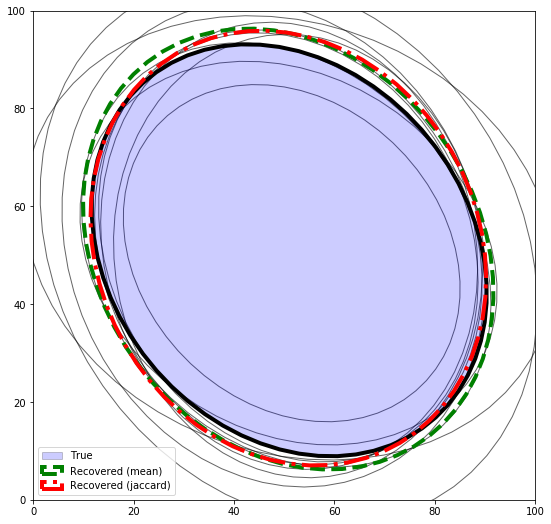

In [10]:
from gzbuilder_analysis.aggregation import make_ellipse
from shapely.affinity import scale as shapely_scale
geoms = drawn_disks.apply(lambda p: make_ellipse(p.to_dict()), axis=1)\
    .dropna().apply(shapely_scale, xfact=3, yfact=3)
true_geom = shapely_scale(
    make_ellipse(disk.to_dict()),
    xfact=3, yfact=3
)
mean_geom = shapely_scale(
    make_ellipse(mean_res.to_dict()),
    xfact=3, yfact=3
)
res_geom = shapely_scale(
    make_ellipse(agg_res.params.disk.to_dict()),
    xfact=3, yfact=3
)
plt.figure(figsize=(9, 9))
ax = plt.gca()
for g in geoms:
    ax.add_patch(PolygonPatch(g, fc='none', ec='k', alpha=0.6))
ax.add_patch(PolygonPatch(true_geom, fc='blue', alpha=0.2, label='True'))
ax.add_patch(PolygonPatch(true_geom, fc='none', ec='k', lw=4, ls='-'))
ax.add_patch(PolygonPatch(mean_geom, fc='none', ec='g', lw=4, ls='--', label='Recovered (mean)'))
ax.add_patch(PolygonPatch(res_geom, fc='none', ec='r', lw=4, ls='-.', label='Recovered (jaccard)'))
plt.legend()
plt.xlim(0, 100)
plt.ylim(0, 100)

What do the jaccard distances from our recovered disks to the true disk look like? (lower is better)

In [11]:
def jaccard_distance(ob1, ob2):
    if ob1.union(ob2).area <= 0:
        return 1
    return 1 - ob1.intersection(ob2).area / ob1.union(ob2).area

print('Jaccard distance to true (mean): {:.4f}'.format(jaccard_distance(true_geom, mean_geom)))
print('Jaccard distance to true (jaccard): {:.4f}'.format(jaccard_distance(true_geom, res_geom)))

Jaccard distance to true (mean): 0.1028
Jaccard distance to true (jaccard): 0.0732
